# Variational Inference: Bayesian Neural Networks
Following https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html to learn

In [24]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set(font_scale=1.5)
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib
import tqdm
import pandas as pd

In [2]:

X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)



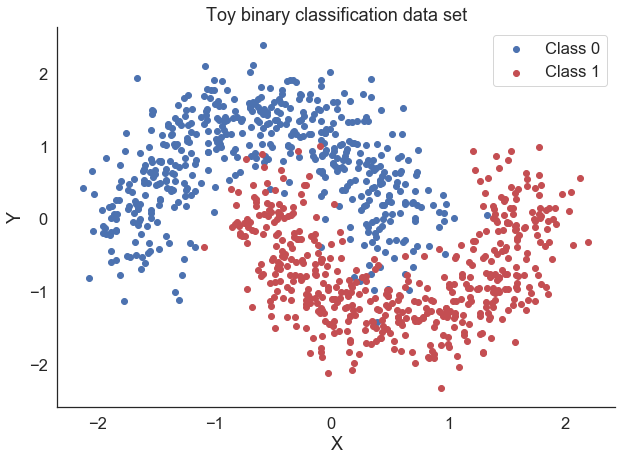

In [3]:

fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');



A neural network is quite simple. The basic unit is a perceptron which is nothing more than logistic regression. We use many of these in parallel and then stack them up to get hidden layers. Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

## 2 hidden layers with 5 neurons each

In [4]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', X_train)
        ann_output = pm.Data('ann_output', Y_train)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '17416' (I am process '11588')


In [5]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [6]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

Average Loss = 198.63: 100%|███████████████████████████████████████████████████| 30000/30000 [00:19<00:00, 1533.22it/s]
Finished [100%]: Average Loss = 198.54


Wall time: 30.8 s


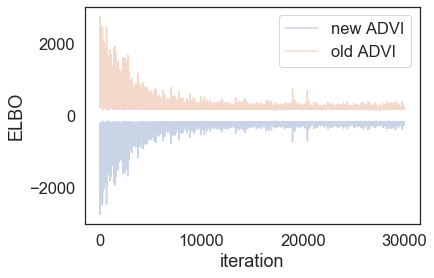

In [7]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.plot(approx.hist, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [8]:
trace = approx.sample(draws=5000)

In [9]:
neural_network.out.distribution.p

sigmoid.0

In [10]:

# create symbolic input
x = T.matrix('X')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={neural_network['ann_input']: x})
# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)

# Create bechmark functions
def production_step1():
    pm.set_data(new_data={'ann_input': X_test, 'ann_output': Y_test}, model=neural_network)
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)

    # Use probability of > 0.5 to assume prediction of class 1
    pred = ppc['out'].mean(axis=0) > 0.5

def production_step2():
    sample_proba(X_test, 500).mean(0) > 0.5



In [11]:
%timeit production_step1()

4.71 s ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit production_step2()

61 ms ± 741 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
pred = sample_proba(X_test, 500).mean(0) > 0.5

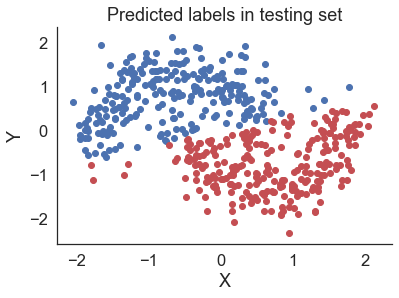

In [14]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [15]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 87.2%


In [16]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [17]:
ppc = sample_proba(grid_2d ,500)

<Figure size 432x288 with 0 Axes>

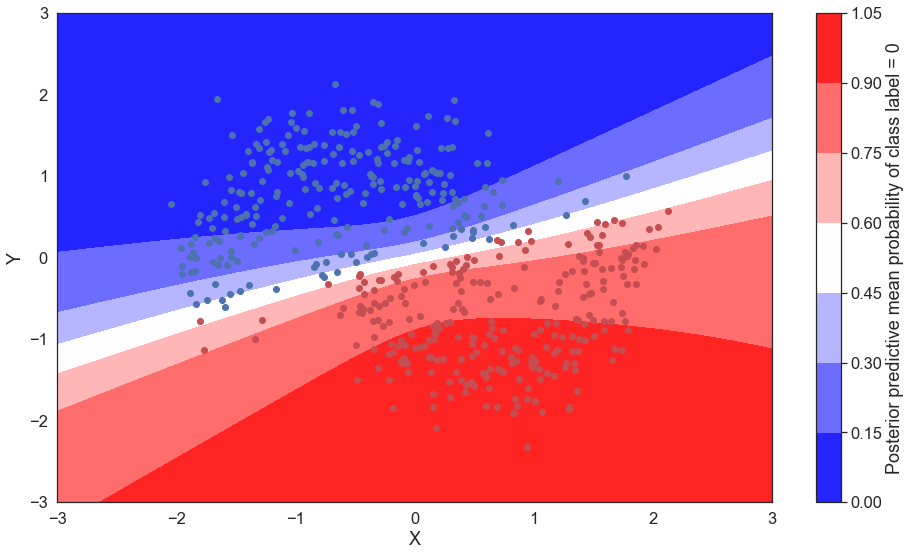

In [18]:

# cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
plt.set_cmap('bwr')
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100),)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');



# Now setup to allow for parameter changes

In [19]:
def construct_nn(ann_input, ann_output, n_hidden=5):

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', X_train)
        ann_output = pm.Data('ann_output', Y_train)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

Average Loss = 146.28: 100%|███████████████████████████████████████████████████| 30000/30000 [00:26<00:00, 1122.26it/s]
Finished [100%]: Average Loss = 146.38


Accuracy = 94.6%


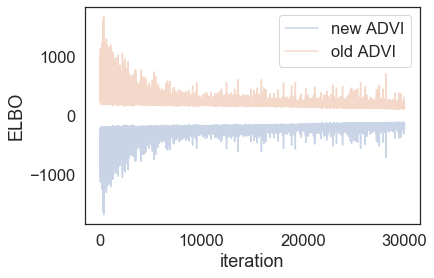

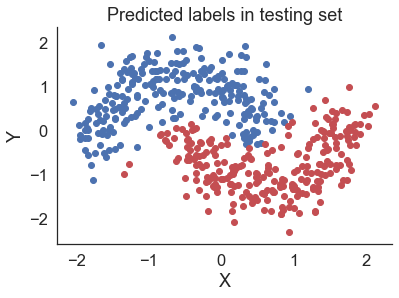

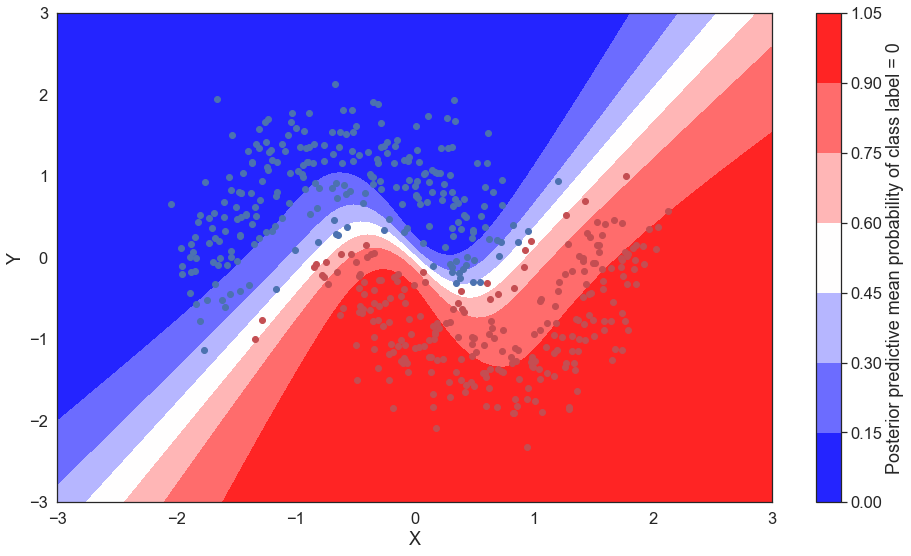

In [20]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

    plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.plot(approx.hist, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');
    
    
trace = approx.sample(draws=5000)



# create symbolic input
x = T.matrix('X')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={neural_network['ann_input']: x})
# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)

# Create bechmark functions
def production_step1():
    pm.set_data(new_data={'ann_input': X_test, 'ann_output': Y_test}, model=neural_network)
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)

    # Use probability of > 0.5 to assume prediction of class 1
    pred = ppc['out'].mean(axis=0) > 0.5

def production_step2():
    sample_proba(X_test, 500).mean(0) > 0.5

production_step1()
production_step2()

pred = sample_proba(X_test, 500).mean(0) > 0.5


fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

ppc = sample_proba(grid_2d ,500)



# cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
plt.set_cmap('bwr')
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100),)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');





## Accuracy by n_hidden

In [21]:
def run_this(n_hidden=5):
    neural_network = construct_nn(X_train, Y_train, n_hidden=n_hidden)
    
    from pymc3.theanof import set_tt_rng, MRG_RandomStreams
    set_tt_rng(MRG_RandomStreams(42))

    with neural_network:
        inference = pm.ADVI()
        approx = pm.fit(n=30000, method=inference)

        plt.plot(-inference.hist, label='new ADVI', alpha=.3)
    plt.plot(approx.hist, label='old ADVI', alpha=.3)
    plt.legend()
    plt.ylabel('ELBO')
    plt.xlabel('iteration');


    trace = approx.sample(draws=5000)



    # create symbolic input
    x = T.matrix('X')
    # symbolic number of samples is supported, we build vectorized posterior on the fly
    n = T.iscalar('n')
    # Do not forget test_values or set theano.config.compute_test_value = 'off'
    x.tag.test_value = np.empty_like(X_train[:10])
    n.tag.test_value = 100
    _sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                       size=n,
                                       more_replacements={neural_network['ann_input']: x})
    # It is time to compile the function
    # No updates are needed for Approximation random generator
    # Efficient vectorized form of sampling is used
    sample_proba = theano.function([x, n], _sample_proba)

    # Create bechmark functions
    def production_step1():
        pm.set_data(new_data={'ann_input': X_test, 'ann_output': Y_test}, model=neural_network)
        ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)

        # Use probability of > 0.5 to assume prediction of class 1
        pred = ppc['out'].mean(axis=0) > 0.5

    def production_step2():
        sample_proba(X_test, 500).mean(0) > 0.5

    production_step1()
    production_step2()

    pred = sample_proba(X_test, 500).mean(0) > 0.5


    fig, ax = plt.subplots()
    ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
    ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
    sns.despine()
    ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

    print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))
    return (Y_test == pred).mean() * 100


1


Average Loss = 170.41: 100%|███████████████████████████████████████████████████| 30000/30000 [00:24<00:00, 1214.40it/s]
Finished [100%]: Average Loss = 170.41


Accuracy = 87.0%
2


Average Loss = 113: 100%|██████████████████████████████████████████████████████| 30000/30000 [00:28<00:00, 1060.68it/s]
Finished [100%]: Average Loss = 112.99


Accuracy = 96.0%
3


Average Loss = 128.59: 100%|███████████████████████████████████████████████████| 30000/30000 [00:29<00:00, 1020.41it/s]
Finished [100%]: Average Loss = 128.57


Accuracy = 94.8%
4


Average Loss = 124.48: 100%|████████████████████████████████████████████████████| 30000/30000 [00:35<00:00, 839.13it/s]
Finished [100%]: Average Loss = 124.52


Accuracy = 96.2%
5


Average Loss = 146.67: 100%|████████████████████████████████████████████████████| 30000/30000 [00:32<00:00, 930.88it/s]
Finished [100%]: Average Loss = 146.73


Accuracy = 95.0%
6


Average Loss = 173.92: 100%|████████████████████████████████████████████████████| 30000/30000 [00:34<00:00, 878.01it/s]
Finished [100%]: Average Loss = 173.8


Accuracy = 93.2%
7


Average Loss = 176.66: 100%|████████████████████████████████████████████████████| 30000/30000 [00:34<00:00, 864.61it/s]
Finished [100%]: Average Loss = 176.6


Accuracy = 92.80000000000001%
8


Average Loss = 177.69: 100%|████████████████████████████████████████████████████| 30000/30000 [00:33<00:00, 905.87it/s]
Finished [100%]: Average Loss = 177.68


Accuracy = 93.4%
9


Average Loss = 185.29: 100%|████████████████████████████████████████████████████| 30000/30000 [00:39<00:00, 752.49it/s]
Finished [100%]: Average Loss = 185.58


Accuracy = 92.60000000000001%
10


Average Loss = 203.71: 100%|████████████████████████████████████████████████████| 30000/30000 [00:40<00:00, 749.74it/s]
Finished [100%]: Average Loss = 203.63


Accuracy = 91.8%
11


Average Loss = 213.65: 100%|████████████████████████████████████████████████████| 30000/30000 [00:36<00:00, 816.07it/s]
Finished [100%]: Average Loss = 213.67


Accuracy = 90.4%
12


Average Loss = 223.63: 100%|████████████████████████████████████████████████████| 30000/30000 [00:30<00:00, 971.66it/s]
Finished [100%]: Average Loss = 223.76


Accuracy = 89.8%
13


Average Loss = 235.99: 100%|████████████████████████████████████████████████████| 30000/30000 [00:33<00:00, 904.05it/s]
Finished [100%]: Average Loss = 235.95


Accuracy = 88.0%
14


Average Loss = 223.86: 100%|████████████████████████████████████████████████████| 30000/30000 [00:35<00:00, 836.64it/s]
Finished [100%]: Average Loss = 224.89


Accuracy = 91.4%
15


Average Loss = 248.14: 100%|████████████████████████████████████████████████████| 30000/30000 [00:35<00:00, 854.00it/s]
Finished [100%]: Average Loss = 248.37


Accuracy = 87.6%
16


Average Loss = 255.71: 100%|████████████████████████████████████████████████████| 30000/30000 [00:36<00:00, 816.30it/s]
Finished [100%]: Average Loss = 255.4


Accuracy = 88.0%
17


Average Loss = 256.89: 100%|████████████████████████████████████████████████████| 30000/30000 [00:38<00:00, 771.58it/s]
Finished [100%]: Average Loss = 256.9


Accuracy = 88.8%
18


Average Loss = 253.72: 100%|████████████████████████████████████████████████████| 30000/30000 [00:37<00:00, 805.68it/s]
Finished [100%]: Average Loss = 253.13


Accuracy = 88.6%
19


Average Loss = 260.39: 100%|████████████████████████████████████████████████████| 30000/30000 [00:39<00:00, 768.01it/s]
Finished [100%]: Average Loss = 260.22


Accuracy = 88.0%


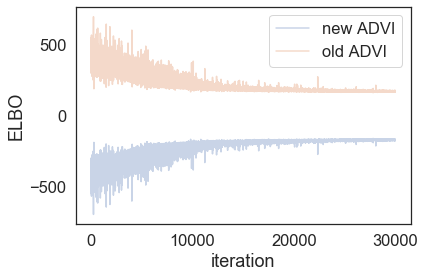

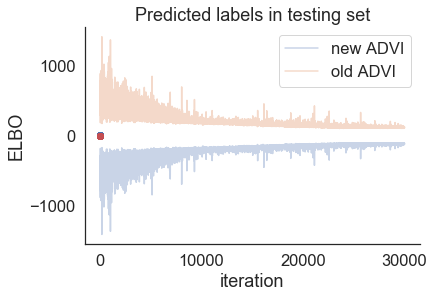

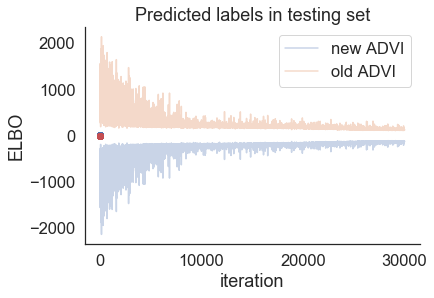

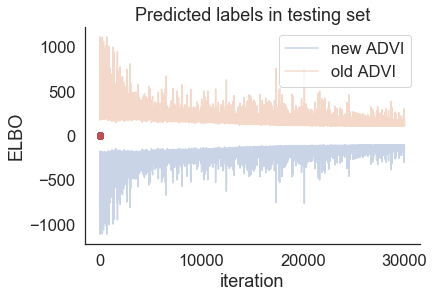

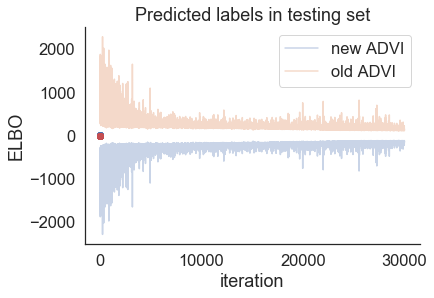

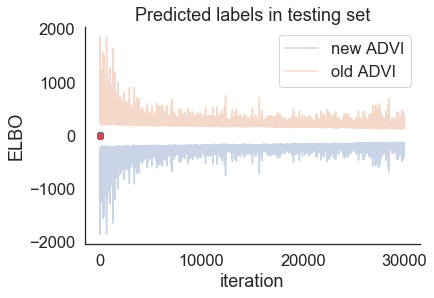

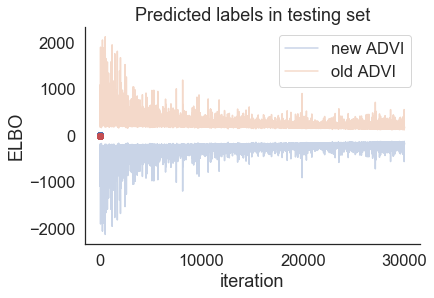

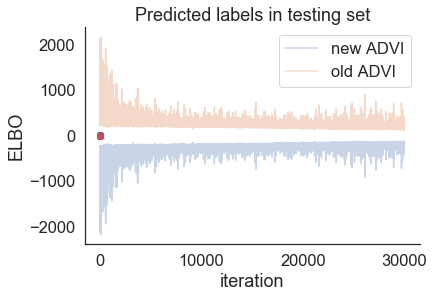

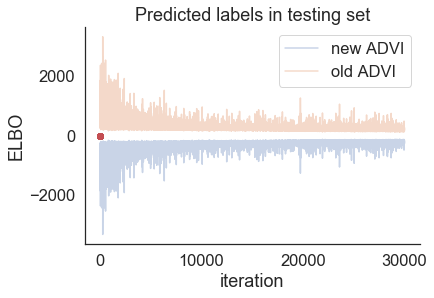

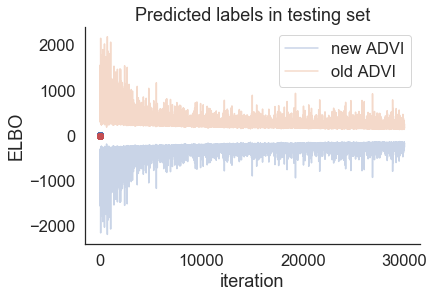

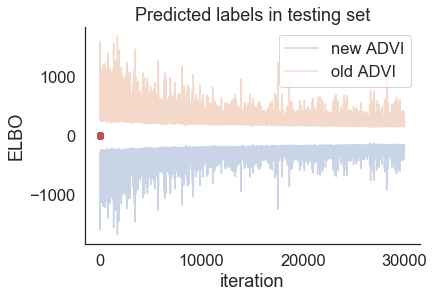

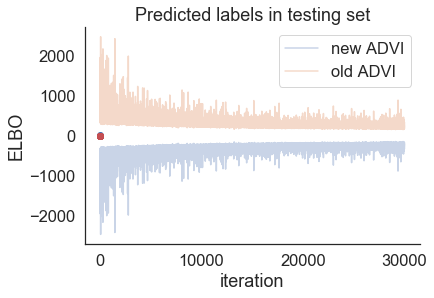

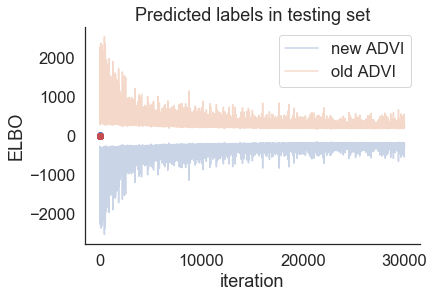

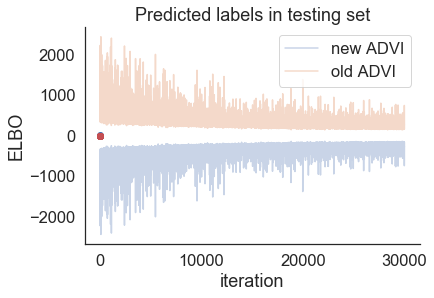

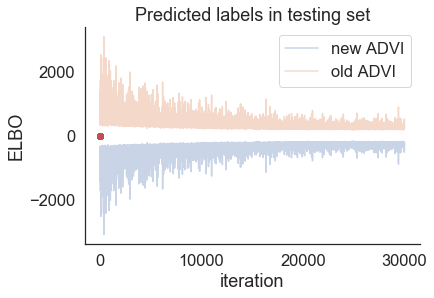

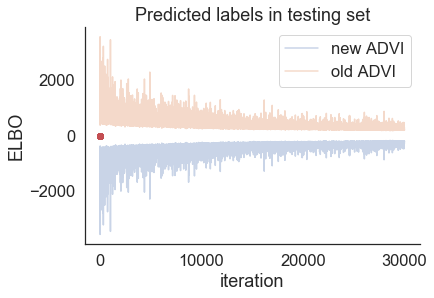

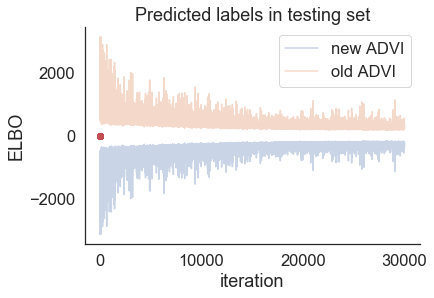

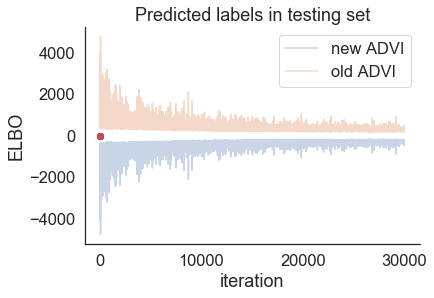

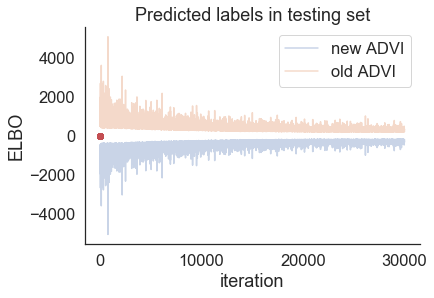

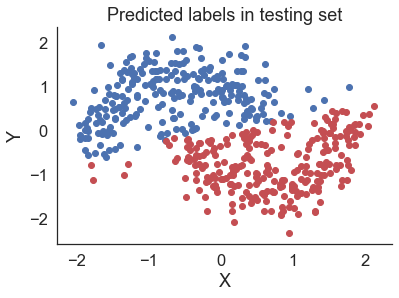

In [22]:
ans = []
for i in range(1, 20):
    print(i)
    ans.append(run_this(i))


In [25]:
acc = pd.DataFrame(ans)
acc

,0
0,87.0
1,96.0
2,94.8
3,96.2
4,95.0
5,93.2
6,92.8
7,93.4
8,92.6
9,91.8


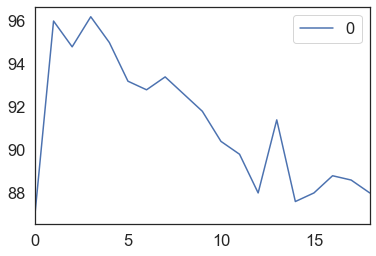

In [26]:
acc.plot()